# 커스텀 데이터 영상 분류 학습

# 데이터 준비


<br>

데이터는 다음과 같이 구성됨

```
dogs/
    train/
        class1/
            file1.jpg
            file2.jpg
             ...
        class2/ 
            file21.jpg
            file22.jpg
             ...    
        class3/
            file31.jpg
            file32.jpg
             ...
        ...
    test/
        class1/
            file8.jpg
            file9.jpg
             ...
        class2/ 
            file28.jpg
            file29.jpg
             ...    
        class3/
            file38.jpg
            file39.jpg
             ...
        ...
    
```

In [1]:
!rm -rf flowers.zip
!wget https://github.com/dhrim/jetson_image/raw/master/data/flowers_prepared.zip
!ls -al  

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
--2021-10-29 13:16:16--  https://github.com/dhrim/jetson_image/raw/master/data/flowers.zip
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dhrim/jetson_image/master/data/flowers.zip [following]
--2021-10-29 13:16:17--  https://raw.githubusercontent.com/dhrim/jetson_image/master/data/flowers.zip
Resolving raw.gith

In [2]:
!rm -rf flowers_prepared
!unzip flowers_prepared.zip
!ls -al flowers_prepared

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
Archive:  flowers.zip
   creating: flowers/
   creating: flowers/test/
   creating: flowers/test/daisy/
  inflating: flowers/test/daisy/406.jpg  
  inflating: flowers/test/daisy/412.jpg  
  inflating: flowers/test/daisy/413.jpg  
  inflating: flowers/test/daisy/407.jpg  
  inflating: flowers/test/daisy/439.jpg  
  inflating: flowers/test/daisy/411.jpg  
  inflating: flowers/test/daisy/405.jpg  
  inflating: flowers/test/daisy/404.jpg  
  inflating: flowers/test/daisy/410.jpg 

# 학습을 위해 수정할 사항

In [3]:
!tree -d flowers_prepared

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
flowers
├── test
│   ├── daisy
│   ├── dandelion
│   ├── rose
│   ├── sunflower
│   └── tulip
├── train
│   ├── daisy
│   ├── dandelion
│   ├── rose
│   ├── sunflower
│   └── tulip
└── val
    ├── daisy
    ├── dandelion
    ├── rose
    ├── sunflower
    └── tulip

18 directories


In [4]:
DATA_NAME = "flowers_prepared"

# 모델 학습

Found 1500 images belonging to 5 classes.
Found 216 images belonging to 5 classes.
load labels. labels= ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 7, 7, 1408)        7768569   
_________________________________________________________________
flatten_1 (Flatten)          (None, 68992)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               17662208  
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
model_output (Dense)         (None, 5)                 1285      
Total params: 25,433,086
Trainable params: 17,664,005
Non-trainable params: 7,769,081
_________

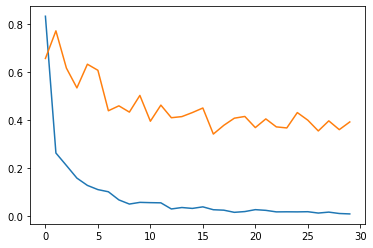

4/4 [==============================] - 0s 101ms/step - loss: 0.3925 - acc: 0.9120
loss= 0.3925214111804962
acc= 0.9120370149612427


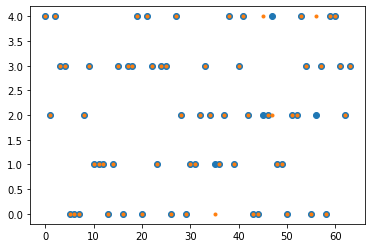

label category index = 4.0
predicted category index = 4
predicted category name = tulip


In [6]:
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications import EfficientNetB2

preprocessor = efficientnet.preprocess_input

BATCH_SIZE = 64

train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=preprocessor
).flow_from_directory(
      DATA_NAME+"/train",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=preprocessor
).flow_from_directory(
      DATA_NAME+"/test",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)

custom_labels = list(test_data_generator.class_indices.keys())
print("load labels. labels=",custom_labels)
CATEGORY_COUNT = len(custom_labels)


conv_layers = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False
conv_layers._name = "model"

model = models.Sequential()

model.add(conv_layers)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(CATEGORY_COUNT, activation='softmax', name="model_output"))

model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])
model.summary()






history = model.fit(
      train_data_generator,
      validation_data=test_data_generator,
      epochs=30
)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()


loss, acc = model.evaluate(test_data_generator)
print("loss=", loss)
print("acc=", acc)



test_x, test_y = test_data_generator.next()
y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=-1)

plt.plot(test_y[:100], "o")
plt.plot(predicted[:100], '.')
plt.show()


print("label category index =", test_y[0])
print("predicted category index =", predicted[0])
print("predicted category name =", custom_labels[predicted[0]])


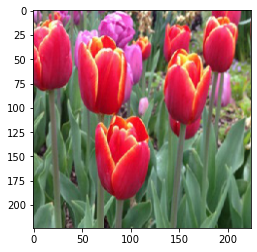

truth=tulip, predicted=tulip



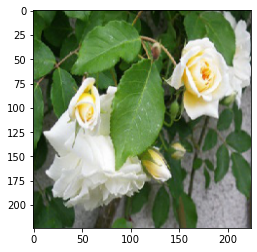

truth=rose, predicted=rose



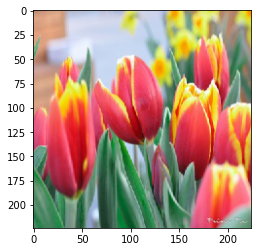

truth=tulip, predicted=tulip



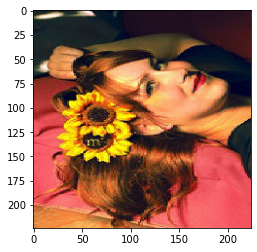

truth=sunflower, predicted=sunflower



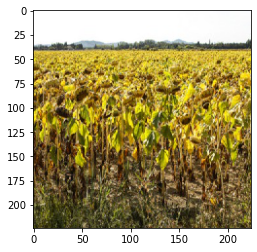

truth=sunflower, predicted=sunflower



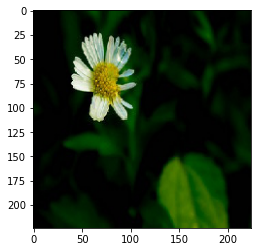

truth=daisy, predicted=daisy



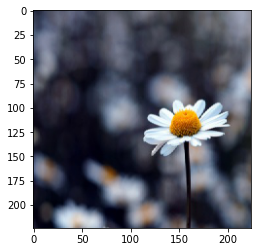

truth=daisy, predicted=daisy



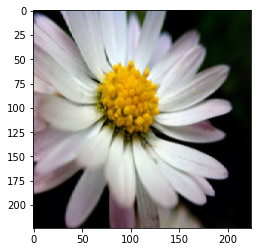

truth=daisy, predicted=daisy



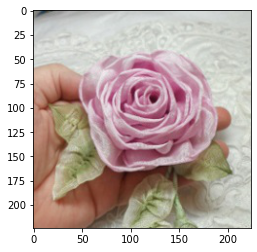

truth=rose, predicted=rose



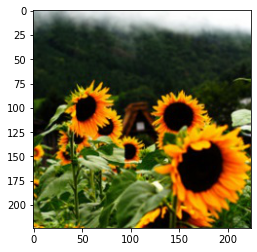

truth=sunflower, predicted=sunflower



In [11]:
for i in range(10):
    plt.imshow(test_x[i].astype(np.int))
    plt.show()
    print("truth={}, predicted={}".format(custom_labels[int(test_y[i])], custom_labels[predicted[i]]))
    print()

# 레이블링 파일 작성

In [ ]:
f = open("labels.txt", "w")
f.write("\n".join(custom_labels))
f.close()

In [ ]:
!cat labels.txt

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
daisy
dandelion
rose
sunflower
tulip

# 모델을 tf 포멧으로 저장

In [ ]:
import os
import tensorflow as tf

model.save("model.tf", save_format="tf")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model.tf/assets


# tf2onnx 설치


In [ ]:
!pip3 install tf2onnx

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


# 모델을 onnx로 변환

In [ ]:
!python -m tf2onnx.convert --opset 10 --saved-model model.tf --output model.onnx --inputs model_input:0[1,224,224,3]

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
/home/ubuntu/anaconda3/envs/tensorflow2_p37/lib/python3.7/runpy.py:125: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2021-10-27 13:01:50,994 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2021-10-27 13:01:51,452 - WARNING - Importing a function (__inference_block5d_se_reduce_layer_call_and_return_conditional_losses_45399) with ops with custom gradients. Will likely fail if a gradient is requested.
2021-10-27 13:01:51,484 - WARNING - Importing a function (__inference_model_layer_call_and_return_conditional_losses_73965) with ops with custom gradients. 